In [1]:
import numpy as np
import seaborn as sns
from dask.distributed import Client
from distributed.deploy.local import LocalCluster
from pycalphad import Database, variables as v
from pduq.dbf_calc import eq_calc_samples
from pduq.uq_plot import plot_phasereg_prob, plot_superimposed
from pycalphad import Database,calculate,equilibrium,variables as v

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask.distributed import Client
from distributed.deploy.local import LocalCluster
from pycalphad import Database, equilibrium, variables as v
from pduq.invariant_calc import invariant_samples
from pduq.uq_plot import plot_contour
sns.set(color_codes=True)

In [3]:
c = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(c)
print(client)

<Client: 'tcp://127.0.0.1:60619' processes=8 threads=8, memory=17.18 GB>


In [4]:
dbf = Database('mcmc_UQ1.tdb')
params = np.load('trace_UQ.npy')[:, -1, :]
print(params)
params = params.reshape(-1,params.shape[-1])
print(params)

[[ -10365.83197294 -147601.78661575    6907.80863556 ... -216655.08275048
  -582252.83020262  -42647.15234038]
 [  -8839.13500538 -140026.89900237    5361.49181276 ... -243066.96416317
  -558205.24369462  -36540.79881318]
 [  -7754.83656119 -109686.13345983    5471.92936546 ... -282804.13037961
  -593155.38559984  -14172.34857235]
 ...
 [ -10111.37009594 -112405.18244399    5130.48775302 ... -305373.58801905
  -512019.34675521  -43698.70139287]
 [  -8733.91190594 -106654.57373118    6128.21508349 ... -255211.73890776
  -526478.9014976   -43380.31403874]
 [  -9979.46494219 -122203.09691451    9097.27168604 ... -134726.18009439
  -499810.19520137  -66049.91239327]]
[[ -10365.83197294 -147601.78661575    6907.80863556 ... -216655.08275048
  -582252.83020262  -42647.15234038]
 [  -8839.13500538 -140026.89900237    5361.49181276 ... -243066.96416317
  -558205.24369462  -36540.79881318]
 [  -7754.83656119 -109686.13345983    5471.92936546 ... -282804.13037961
  -593155.38559984  -14172.34857

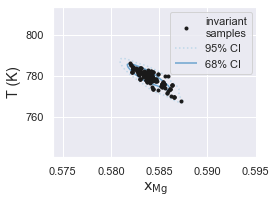

In [18]:
X = .2  # X_MG guess for invariant
P = 101324  # pressure
Tl = 600  # lower temperature bound for invariant
Tu = 1400  # upper temperature bound for invariant
comp = 'MG'  # species to reference for composition

Tv, phv, bndv = invariant_samples(
    dbf, params, X, P, Tl, Tu, comp)
# form an array for the invariant points
points = np.zeros((len(Tv), 2))
points[:, 0] = bndv[:, 1]
points[:, 1] = Tv
c = sns.color_palette("Blues", 2)

plt.figure(figsize=(4, 3))

# plot the raw invariant points
plt.plot(points[:, 0], points[:, 1], 'k.',
         label="invariant\nsamples")

# plot KDE estimated uncertainty intervals
plot_contour(points, c, 0.6)

plt.xlabel(r'$\mathrm{x_{Mg}}$', fontsize="large")
plt.ylabel('T (K)', fontsize="large")
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# equlibrium conditions including the pressure (Pa),
# temperature evaluation points (K), and molar
# composition MG evaluation points
conds = {v.P: 101325, v.T: (300, 1500, 50), v.X('NB'): (0, 1, 0.1)}

# perform the equilibrium calculation
eq = eq_calc_samples(dbf, conds, params, client=client)

In [ ]:
# We can assign colors to the phase names so
# that they are the same in all of the plots
phaseL = list(np.unique(eq.get('Phase').values))
if '' in phaseL: phaseL.remove('')
nph = len(phaseL)
colorL = sns.color_palette("cubehelix", nph+2)
cdict = {}
for ii in range(nph):
    cdict[phaseL[ii]] = colorL[ii]

# we can also specify a dictionary to have pretty
# labels (even LaTeX) in our plots
#phase_label_dict = {
#    'LIQUID':'liquid', 'FCC_A1':'FCC', 'HCP_A3':'HCP',
#    'CUMG2':r'$\mathrm{Cu{Mg}_2}$', 'LAVES_C15':'Laves'}

# plot the superimposed phase diagrams
plot_superimposed(eq, 'MG', alpha=0.2,
                  xlims=[-.005, 1.005], cdict=cdict,
                  phase_label_dict=phase_label_dict,
                  figsize=(5, 4))

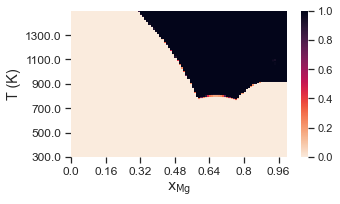

In [6]:
plot_phasereg_prob(
    eq, ['LIQUID'], coordplt=['X_MG', 'T'], figsize=(5, 3))

In [7]:
from pduq.uq_plot import plot_phasefracline

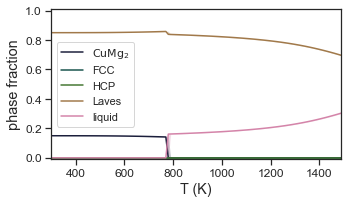

In [8]:
# define a dictionary fixing the composition. We need to pick
# a value for X_MG that is represented in the eq object
coordD = {'X_MG':0.1}

# plot the phase fraction versus composition
# cdict and phase_label_dict are the same as in the previous example
plot_phasefracline(eq, coordD, xlabel='T (K)', cdict=cdict,
                      phase_label_dict=phase_label_dict, figsize=(5, 3))

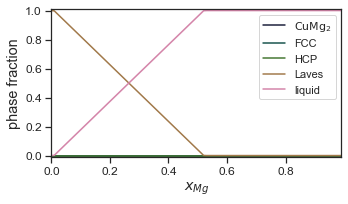

In [9]:
# define a dictionary fixing the temperature. We need to pick
# a value for T that is represented in the eq object
coordD = {'T':1000}

# plot the phase fraction versus composition
# cdict and phase_label_dict are the same as in the previous example
plot_phasefracline(eq, coordD, xlabel=r"$x_{Mg}$", cdict=cdict,
                      phase_label_dict=phase_label_dict, figsize=(5, 3))

In [10]:
from pduq.uq_plot import plot_property

starting GM evaluations for the CUMG2 phase
phase is a line compound
starting GM evaluations for the FCC_A1 phase
starting GM evaluations for the HCP_A3 phase
starting GM evaluations for the LAVES_C15 phase
starting GM evaluations for the LIQUID phase


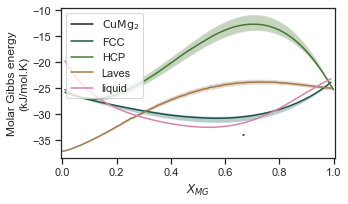

In [11]:
comps = ['MG', 'CU', 'VA']  # species to consider
T = 650  # temperature in Kelvin
prop = 'GM'  # property of interest (molar Gibbs energy)
ylabel = 'Molar Gibbs energy\n(kJ/mol.K)'  # y-axis label
yscale = 1e-3  # we want to scale the Gibbs energy to give kJ/mol.

# we can now plot the property. Note that phaseL, phase_label_dict,
# and cdict are defined in the phase diagram prediction example
plot_property(dbf, comps, phaseL, params, T, prop,
                 phase_label_dict=phase_label_dict,
                 ylabel=ylabel, yscale=yscale, cdict=cdict,
                 xlim=[-0.005, 1.005], figsize=(5, 3))

starting HM_MIX evaluations for the CUMG2 phase
phase is a line compound
starting HM_MIX evaluations for the HCP_A3 phase
starting HM_MIX evaluations for the LAVES_C15 phase
starting HM_MIX evaluations for the LIQUID phase


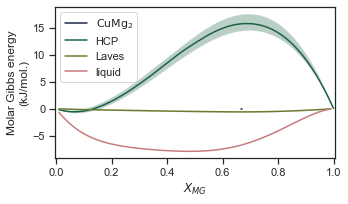

In [17]:
T = 298.15  # temperature in Kelvin
prop = 'HM_MIX'  # property of interest (molar enthalpy of mixing
ylabel = 'Molar Gibbs energy\n(kJ/mol.)'  # y-axis label
yscale = 1e-3  # we want to scale the Gibbs energy to give kJ/mol.

# we can now plot the property. Note that phaseL, phase_label_dict,
# and cdict are defined in the phase diagram prediction example
plot_property(dbf, comps, phaseL, params, T, prop,
                 phase_label_dict=phase_label_dict,
                 ylabel=ylabel, yscale=yscale, cdict=cdict,
                 xlim=[-0.005, 1.005], figsize=(5, 3))

example 1